# HW 6 (Answer 3)
## Submitted by : Aman jain (aj644) 

# Question 3 

# Answer 3(a) 

X = $ \begin{bmatrix}
- & 8 & 4 & 4\\ 
 4& 4 & 2 & -
\end{bmatrix} $

<br> expected_rating_1 = 6
<br> expected_rating_2 = 3

<br> column 1,2 corresponds to easy graders, while column 3,4 corresponds to hard graders. 

<br> <b> Part a - Averaging </b>

<br> $g^{avg}_{1}$ = avg(8,4,4) = 16/3 = 5.333
<br> $g^{avg}_{2}$ = avg(4,4,2) = 10/3 = 3.333


<br> <b> Part b - Matrix completion </b>

<br> $\hat{A}$ = $ \begin{bmatrix}
8 & 8 & 4 & 4\\ 
 4& 4 & 2 & 2
\end{bmatrix} $

<br> $g^{mc}_{1}$ = avg(8,8,4,4) = 24/4 = 6
<br> $g^{mc}_{2}$ = avg(4,4,2,2) = 12/4 = 3

<br><b>Logic for matrix completion:</b> Since grader 1,2 are easy graders and 3,4 are hard graders. I have used rating given within these sub group to fill the missing grades. This logic further makes sense given that on project 1 both 3,4 have given same rating, similarily for project 2 both 1,2 have given the same rating. 

<br><b> matrix completition method gives more accurate results </b> wrt expected rating (actually same as expected rating). While for avergae method, project 1 is at disadvantage as it gets 2 hard graders hence its predicted rating is less than expected (5.33 vs 6). While project 2 is at advantage as it gets 2 easy graders hence its predicted rating is more than expected (3.33 vs 3). 



# Answer 3(b) 

In [178]:
using LowRankModels, Random, LinearAlgebra, Plots, Statistics, CSV

Note: Throughout the notebook, we will be using random seeds for reproducibility. Do not remove the corresponding commands.

## (a) Synthetic data

We first take a look at a demo. We generate a synthetic dataset that contains ratings with integer values 1-5. 1 is lowest and 5 is highest. The rows are aligned by projects; the columns are aligned by reviewers.

In [179]:
# rows are papers, columns are reviewers
Random.seed!(1)  # seed random seed, for reproducibility

# problem dimensions
n,d = 100,200    # n projects, d reviewers

# observed entries
Ω = findall(rand(n,d) .< .1)  # Ω is a matrix with the same shape as our 10% of entries are observed. 

# latent parameters 
θ = rand(n)      # quality of paper 
a = rand(d)      # coefficient of reviewer
b = rand(d)      # offset of reviewer

# data matrix
A = θ * a' .+ b'

a = vec(A)
t = [quantile(a,.22), quantile(a,.31), quantile(a,.53), quantile(a,.88)] # thresholds

# generate ratings matrix
R = ones(Int, n, d)
for ti in t
    R += A .> ti
end

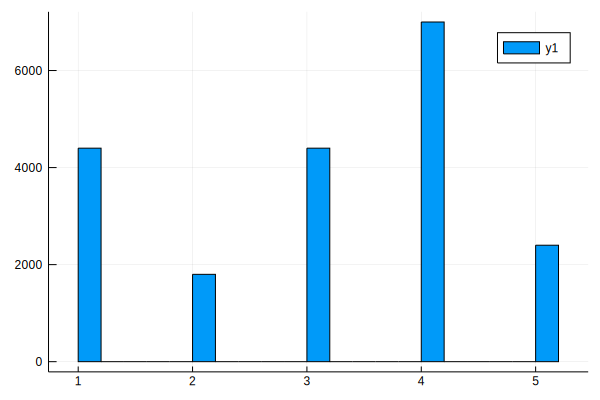

In [180]:
# We can plot histogram of scores
histogram(vec(R))

In [181]:
# compute observed average scores on all projects
observed_average_score = []
for i=1:n
    append!(observed_average_score, mean(R[filter(t -> t[1] == i, Ω)]))
end

In [182]:
# compute true average scores on all projects
true_average_score = mean(R, dims=2);

In [183]:
print("Observed total score is:", sum(observed_average_score), "-->")
println("True total score is:", sum(true_average_score), "-->")

Observed total score is:310.9876267159367-->True total score is:305.99999999999994-->


Next, we take a look at different matrix completion scenarios.

## Fit ratings with Quadratic Loss

We first fit a low rank model to this simulated data using quadratic loss and regularizers.

In [184]:
Random.seed!(1)      
loss = QuadLoss()    # quadratic loss
reg = QuadReg(.0001) # a tiny bit of quadratic regularization
k = 2                # we'll add the offset separately below 
glrm = GLRM(R, loss, reg, reg, k, obs=Ω)  # the GLRM object stores the model, data, and parameter estimate
add_offset!(glrm)    # adds an offset to the model

# fit low rank model
fit!(glrm)                            # alternating minimization
Rhat_quad = impute(glrm)                   # imputed values 
MAE_quad = sum(abs.(vec(Rhat_quad - R)))/(n*d)  # mean absolute error
@show MAE_quad;

Fitting GLRM
Iteration 10: objective value = 270.86675290009435
Iteration 20: objective value = 120.35061353861308
Iteration 30: objective value = 116.57538786023763
Iteration 40: objective value = 115.74976110738844
Iteration 50: objective value = 114.71208781361162
MAE_quad = 0.23410370513231119


To evaluate the performance of our predictions, we define the following terms:

1. observed average score: the average of all scores we observe on a single project.
2. true average score: the average of all scores on a single project, whether we observed or not. These scores are regarded as true labels.
3. predicted score: the average of all predicted scores on a single project.

In [185]:
# predicted scores on all projects
pred_score_quad = mean(Rhat_quad, dims=2);

**Question**: 

Plot histograms of
1. the difference between the observed average score and the true average score
2. the difference between the predicted average score and the true average score

Notice that for real data, the true average score is not known, while the observed average score is known and the predicted average score is computable.
Which predicts the true average score best? Compare the variance of the errors. 

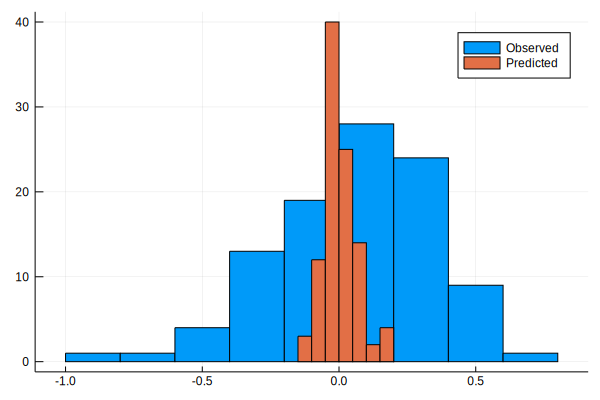

In [186]:
"YOUR WORK HERE: histograms"
#historgram of true and observed
histogram(observed_average_score-true_average_score, label="Observed")
histogram!(pred_score_quad-true_average_score, label=["Predicted"])


In [187]:
#"YOUR WORK HERE: variance comparison"
print("Variance of observed errors is: ", std(observed_average_score-true_average_score)^2, " and ")
print("Variance of predicted errors is: ", std(pred_score_quad-true_average_score)^2)

Variance of observed errors is: 0.08278512751364836 and Variance of predicted errors is: 0.0033867810052641122

In [188]:
MAE_true_avg_observed = sum(abs.(vec(observed_average_score - true_average_score)))/(n)

0.2346883266503254

<b> as seen from histograms as well, variance of predicted error is less than variance of observed errors (0.0033 vs 0.0827) </b>

## Fit with the BvSLoss function

Notice that ratings are ordinal, taking values between 1 and 5. 
Hence it makes more sense to use an ordinal loss. 
We will use BvSLoss (Bigger-versus-Smaller) here. 
As we saw in class, using the BvSLoss is equivalent to mapping the matrix through the ordinal embedding
    
    1 => [0, 0, 0, 0]
    2 => [1, 0, 0, 0]
    3 => [1, 1, 0, 0]
    4 => [1, 1, 1, 0]
    5 => [1, 1, 1, 1]
    
 and fitting the resulting matrix with the hinge loss or logistic loss.
 
 Fit a model to the data using the BvSLoss and a nonnegative regularizer.

In [189]:
# form a low rank model by selecting appropriate losses, regularizer, and rank k
loss = BvSLoss(5, bin_loss=LogisticLoss())    # BvSLoss with 5 levels, using Logistic Loss as the underlying binary loss
# you could also ask for nonnegative coefficients:
rx = lastentry1(NonNegConstraint())
ry = OrdinalReg(NonNegConstraint())
# rx = lastentry1(QuadReg(.0001))
# ry = OrdinalReg(QuadReg(.0001))
k = 2                # we'll add the offset separately below 
glrm = GLRM(R, loss, rx, ry, k, obs=Ω)  # the GLRM object stores the model, data, and parameter estimate

# initialize with random positive numbers
glrm.X = rand(size(glrm.X)...)
glrm.Y = rand(size(glrm.Y)...)

# fit low rank model 
fit!(glrm)                            # alternating minimization
Rhat_bvs = impute(glrm)                   # imputed values 
MAE_bvs = sum(abs.(vec(Rhat_bvs - R)))/(n*d)  # mean absolute error
@show MAE_bvs;

Fitting GLRM
Iteration 10: objective value = 1506.3735416871932
Iteration 20: objective value = 966.7668252030795
Iteration 30: objective value = 728.9937554169037
Iteration 40: objective value = 599.5393926975701
Iteration 50: objective value = 506.9281839227593
Iteration 60: objective value = 425.42492902125724
Iteration 70: objective value = 362.23914092113
Iteration 80: objective value = 318.1535002847925
Iteration 90: objective value = 288.01937136724234
Iteration 100: objective value = 266.69173185597634
MAE_bvs = 0.1275


In [190]:
pred_score_bvs = mean(Rhat_bvs, dims=2);

**Question**: 

Plot a histogram of the error between the predicted score using the BvSLoss and the true average score.

Compare the accuracy of the predictions from the model fit with BvSLoss and QuadLoss. Which predicts the ratings better (say, in mean absolute error)? Which predicts the true average score better (say, in mean absolute error)? 

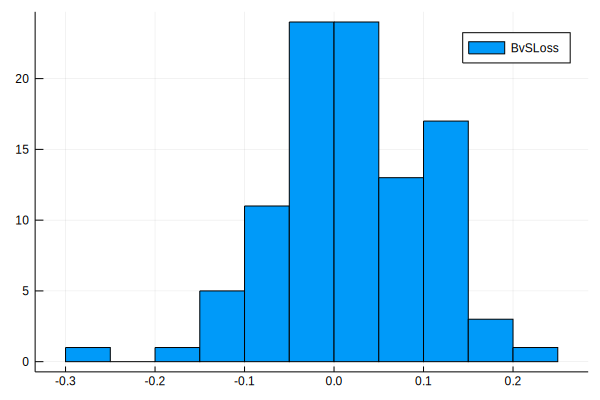

In [191]:
#"YOUR WORK HERE: histograms"
histogram(pred_score_bvs-true_average_score, label="BvSLoss")

In [192]:
MAE_true_avg_bvs = sum(abs.(vec(pred_score_bvs - true_average_score)))/(n)
MAE_true_avg_quad = sum(abs.(vec(pred_score_quad - true_average_score)))/(n)

print("MAE for true average and BvS is: ", MAE_true_avg_bvs, " and ")
print("MAE for true average and quad is: ", MAE_true_avg_quad)

MAE for true average and BvS is: 0.0653 and MAE for true average and quad is: 0.043300027504531255

MAE for BvS (0.1275) is less than MAE for quad (0.2341). <b> Hence BvS predicts ratings better.  </b>
however, MAE for average rating for quad (0.043) is better than MAE for avg rating for BvS (0.065). <b> Hence Quad predicts true average score better. </b>

**Question**: 

Fit at least one more model to this dataset. How did you choose which loss or regularizers to use? How does the error of your method compare to the error of the two models we fit above?

The ORIE 4741 must choose a method to grade your projects based on observable data. Based on these results on synthetic data, how would you like them to grade you? (Note: you'll have a chance to answer again after you see the real data.)

1. average the observed scores 
2. average the scores imputed by matrix completion with quadratic loss
3. average the scores imputed by matrix completion with BvSLoss
4. average the scores imputed by matrix completion with my model

# Answer

<br> <b> Answer: </b>

<br> <b>My model will be with One vs All loss function and quad regularization (My_model no. 5 below)</b>. Since the problem set is categorical context, categorical/ordinal loss functions (One vs all, multinomial loss functions) outperform huber and hinge loss functions (models 4-8 vs models 1-3). Wrt Regularizer, it does not have significant impact on accuracy numbers, in fact quad regularizer only gives slightly better results than than zero regularizer, nonnegative constriant or ordinal constraint). 

<br> <b> MAE for My model is better than both quad and BvS </b> 
<br> MAE for BvS is 0.1275
<br> MAE for quad is 0.2341
<br> MAE for My Model is 0.11

<br> <b> MAE for averages is still best for quad model, however i would prefer to use my model as it is quite near to quad model wrt MAE for average but much better in terms of model MAE (as discussed above)</b> 
<br> MAE for true average and <b> observed is: 0.234 </b>
<br> MAE for true average and <b> quad is: 0.043</b>
<br> MAE for true average and <b>BvS is: 0.0653</b>
<br> MAE for true average and <b>My Model is: 0.050</b>

## My_Model 1 (huber loss with quad reg) 

In [193]:
Random.seed!(1)      
loss = HuberLoss()    # huber loss
reg = QuadReg(.0001) # a tiny bit of quadratic regularization
k = 2               # we'll add the offset separately below 
glrm = GLRM(R, loss, reg, reg, k, obs=Ω)  # the GLRM object stores the model, data, and parameter estimate
add_offset!(glrm)    # adds an offset to the model

# fit low rank model 
fit!(glrm)                            # alternating minimization
Rhat_new_model = impute(glrm)                   # imputed values 
MAE_new_model = sum(abs.(vec(Rhat_new_model - R)))/(n*d)  # mean absolute error
print(MAE_new_model)

Fitting GLRM
Iteration 10: objective value = 442.8270148371224
Iteration 20: objective value = 313.3939611234319
Iteration 30: objective value = 290.2812062623841
Iteration 40: objective value = 262.84008592388744
Iteration 50: objective value = 227.32264270463585
Iteration 60: objective value = 184.77583007893085
Iteration 70: objective value = 141.8098466092143
Iteration 80: objective value = 122.42785091551949
Iteration 90: objective value = 117.75778800056294
Iteration 100: objective value = 116.34670011607734
0.2527143397588435

In [194]:
pred_score_new_model = mean(Rhat_new_model, dims=2);
MAE_true_avg_new_model = sum(abs.(vec(pred_score_new_model - true_average_score)))/(n)

0.049867973723637944

## My_Model 2 (Ordinal hinge loss with quad reg) 

In [195]:
Random.seed!(1)      
loss = OrdinalHingeLoss()    # huber loss
reg = QuadReg(.0001) # a tiny bit of quadratic regularization
k = 2               # we'll add the offset separately below 
glrm = GLRM(R, loss, reg, reg, k, obs=Ω)  # the GLRM object stores the model, data, and parameter estimate
add_offset!(glrm)    # adds an offset to the model

# fit low rank model 
fit!(glrm)                            # alternating minimization
Rhat_new_model = impute(glrm)                   # imputed values 
MAE_new_model = sum(abs.(vec(Rhat_new_model - R)))/(n*d)  # mean absolute error
print(MAE_new_model)

Fitting GLRM
Iteration 10: objective value = 841.3449655127715
Iteration 20: objective value = 778.4085940997564
Iteration 30: objective value = 754.4174779378748
Iteration 40: objective value = 733.1027095030404
Iteration 50: objective value = 711.4155476139401
Iteration 60: objective value = 683.4636371399733
Iteration 70: objective value = 660.0189113931622
Iteration 80: objective value = 640.4032105791218
Iteration 90: objective value = 622.7929839728206
Iteration 100: objective value = 608.6649046798191
0.4411

In [196]:
pred_score_new_model = mean(Rhat_new_model, dims=2);
MAE_true_avg_new_model = sum(abs.(vec(pred_score_new_model - true_average_score)))/(n)

0.3453

## My_Model 3 (Huber loss with zero reg) 

In [197]:
Random.seed!(1)      
loss = HuberLoss()    # huber loss
reg = ZeroReg() # a tiny bit of quadratic regularization
k = 2               # we'll add the offset separately below 
glrm = GLRM(R, loss, reg, reg, k, obs=Ω)  # the GLRM object stores the model, data, and parameter estimate
add_offset!(glrm)    # adds an offset to the model

# fit low rank model 
fit!(glrm)                            # alternating minimization
Rhat_new_model = impute(glrm)                   # imputed values 
MAE_new_model = sum(abs.(vec(Rhat_new_model - R)))/(n*d)  # mean absolute error
print(MAE_new_model)

Fitting GLRM
Iteration 10: objective value = 442.9855758817226
Iteration 20: objective value = 313.3855567991193
Iteration 30: objective value = 290.28755765609424
Iteration 40: objective value = 263.00702026383215
Iteration 50: objective value = 227.6861372923984
Iteration 60: objective value = 185.20783580476373
Iteration 70: objective value = 143.52754198652542
Iteration 80: objective value = 124.19525908875357
Iteration 90: objective value = 119.21137366634156
Iteration 100: objective value = 117.26417805163135
0.25364489453304023

In [198]:
pred_score_new_model = mean(Rhat_new_model, dims=2);
MAE_true_avg_new_model = sum(abs.(vec(pred_score_new_model - true_average_score)))/(n)

0.04965961187720997

## My_Model 4 (One vs all loss with zero reg) 

In [199]:
# form a low rank model by selecting appropriate losses, regularizer, and rank k
loss = OvALoss(5, bin_loss=LogisticLoss())    # BvSLoss with 5 levels, using Logistic Loss as the underlying binary loss
# you could also ask for nonnegative coefficients:
reg = ZeroReg()
# rx = lastentry1(NonNegConstraint())
# ry = OrdinalReg(NonNegConstraint())
# rx = lastentry1(QuadReg(.0001))
# ry = OrdinalReg(QuadReg(.0001))
k = 2                # we'll add the offset separately below 
glrm = GLRM(R, loss, reg, reg, k, obs=Ω)  # the GLRM object stores the model, data, and parameter estimate

# initialize with random positive numbers
glrm.X = rand(size(glrm.X)...)
glrm.Y = rand(size(glrm.Y)...)

fit!(glrm)                            # alternating minimization
Rhat_new_model = impute(glrm)                   # imputed values 
MAE_new_model = sum(abs.(vec(Rhat_new_model - R)))/(n*d)  # mean absolute error
print(MAE_new_model)

Fitting GLRM
Iteration 10: objective value = 1971.8184137561884
Iteration 20: objective value = 844.8950390124877
Iteration 30: objective value = 650.2695843004117
Iteration 40: objective value = 592.2107865872473
Iteration 50: objective value = 556.8050805149411
Iteration 60: objective value = 530.8453724167839
Iteration 70: objective value = 509.82268639588585
Iteration 80: objective value = 492.47787729383964
Iteration 90: objective value = 477.91817156025974
Iteration 100: objective value = 465.8355710719174
0.12095

In [200]:
pred_score_new_model = mean(Rhat_new_model, dims=2);
MAE_true_avg_new_model = sum(abs.(vec(pred_score_new_model - true_average_score)))/(n)

0.05174999999999997

## My_Model 5  (One vs all loss with quad reg) 

In [201]:
# form a low rank model by selecting appropriate losses, regularizer, and rank k
loss = OvALoss(5, bin_loss=LogisticLoss())    # BvSLoss with 5 levels, using Logistic Loss as the underlying binary loss
# you could also ask for nonnegative coefficients:
reg = QuadReg(.0001)
# rx = lastentry1(NonNegConstraint())
# ry = OrdinalReg(NonNegConstraint())
# rx = lastentry1(QuadReg(.0001))
# ry = OrdinalReg(QuadReg(.0001))
k = 2                # we'll add the offset separately below 
glrm = GLRM(R, loss, reg, reg, k, obs=Ω)  # the GLRM object stores the model, data, and parameter estimate

# initialize with random positive numbers
glrm.X = rand(size(glrm.X)...)
glrm.Y = rand(size(glrm.Y)...)

fit!(glrm)                            # alternating minimization
Rhat_new_model = impute(glrm)                   # imputed values 
MAE_new_model = sum(abs.(vec(Rhat_new_model - R)))/(n*d)  # mean absolute error
print(MAE_new_model)

Fitting GLRM
Iteration 10: objective value = 2006.8421996383931
Iteration 20: objective value = 831.8688598069551
Iteration 30: objective value = 654.6575297329053
Iteration 40: objective value = 596.2447994237449
Iteration 50: objective value = 561.2705174366366
Iteration 60: objective value = 535.1888556898175
Iteration 70: objective value = 514.2222635302059
Iteration 80: objective value = 496.79549880418597
Iteration 90: objective value = 482.25224036171204
Iteration 100: objective value = 470.30489281776045
0.11845

In [202]:
pred_score_new_model = mean(Rhat_new_model, dims=2);
MAE_true_avg_new_model = sum(abs.(vec(pred_score_new_model - true_average_score)))/(n)

0.05025

## My_Model 6 (Multinomial loss function with Quad reg)

In [203]:
# form a low rank model by selecting appropriate losses, regularizer, and rank k
loss = MultinomialLoss(5)    # BvSLoss with 5 levels, using Logistic Loss as the underlying binary loss
# you could also ask for nonnegative coefficients:
reg = QuadReg(.0001)
# rx = lastentry1(NonNegConstraint())
# ry = OrdinalReg(NonNegConstraint())
# rx = lastentry1(QuadReg(.0001))
# ry = OrdinalReg(QuadReg(.0001))
k = 2                # we'll add the offset separately below 
glrm = GLRM(R, loss, reg, reg, k, obs=Ω)  # the GLRM object stores the model, data, and parameter estimate

fit!(glrm)                            # alternating minimization
Rhat_new_model = impute(glrm)                   # imputed values 
MAE_new_model = sum(abs.(vec(Rhat_new_model - R)))/(n*d)  # mean absolute error
print(MAE_new_model)

Fitting GLRM
Iteration 10: objective value = 1381.1112618583898
Iteration 20: objective value = 185.6911248768986
Iteration 30: objective value = 75.89224014122453
Iteration 40: objective value = 42.13749628534655
Iteration 50: objective value = 25.97975564651406
Iteration 60: objective value = 16.872284870162133
Iteration 70: objective value = 11.209466106624703
Iteration 80: objective value = 7.686190586659845
Iteration 90: objective value = 5.562475441782633
Iteration 100: objective value = 4.249620485375777
0.1238

In [204]:
pred_score_new_model = mean(Rhat_new_model, dims=2);
MAE_true_avg_new_model = sum(abs.(vec(pred_score_new_model - true_average_score)))/(n)

0.04999999999999998

## My_Model 7 (Multinomial loss function, with zero reg)

In [205]:
# form a low rank model by selecting appropriate losses, regularizer, and rank k
loss = MultinomialLoss(5)    # BvSLoss with 5 levels, using Logistic Loss as the underlying binary loss
# you could also ask for nonnegative coefficients:
reg = ZeroReg()
# rx = lastentry1(NonNegConstraint())
# ry = OrdinalReg(NonNegConstraint())
# rx = lastentry1(QuadReg(.0001))
# ry = OrdinalReg(QuadReg(.0001))
k = 2                # we'll add the offset separately below 
glrm = GLRM(R, loss, reg, reg, k, obs=Ω)  # the GLRM object stores the model, data, and parameter estimate

fit!(glrm)                            # alternating minimization
Rhat_new_model = impute(glrm)                   # imputed values 
MAE_new_model = sum(abs.(vec(Rhat_new_model - R)))/(n*d)  # mean absolute error
print(MAE_new_model)

Fitting GLRM
Iteration 10: objective value = 1344.107884490303
Iteration 20: objective value = 755.8299768099911
Iteration 30: objective value = 325.1535884691473
Iteration 40: objective value = 117.23381724430136
Iteration 50: objective value = 59.01211489859437
Iteration 60: objective value = 38.07850713442325
Iteration 70: objective value = 26.03490626598752
Iteration 80: objective value = 18.89806925330699
Iteration 90: objective value = 14.52960749643304
Iteration 100: objective value = 11.655339225546756
0.13615

In [206]:
pred_score_new_model = mean(Rhat_new_model, dims=2);
MAE_true_avg_new_model = sum(abs.(vec(pred_score_new_model - true_average_score)))/(n)

0.049450000000000015

# (b) Fall 2017 ORIE4741 project review data

Now let's see how well matrix completion works on the real data!
The rating scores are ordinal and have 6 possible values.
Here, we don't have access to the true average score. 

In [207]:
ratings = CSV.read("ratings.csv");

In [208]:
staff_score = ratings[:, 2]; # rating scores given by staff
average_score = ratings[:, 3]; # rating scores from averages of peer review scores
R_real = convert(Matrix, ratings[:, 4:end]); # peer review grades
Ω_real = findall(.!ismissing.(R_real)); # observed entries
n_real, p_real = size(R_real);

First, let's plot the average scores

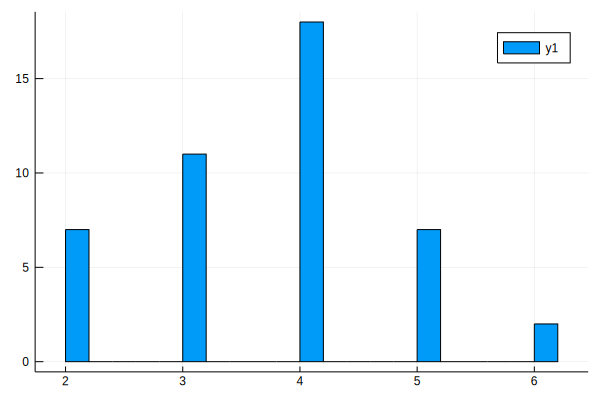

In [209]:
histogram(average_score, nbins=20)

## Fit ratings with several losses

First, we choose Huber loss with nonnegative constraint.

In [210]:
# form a low rank model by selecting appropriate losses, regularizer, and rank k
Random.seed!(1)
loss = HuberLoss() 
reg = NonNegConstraint() 
k = 2                # we'll add the offset separately below 
glrm = GLRM(R_real, loss, reg, reg, k, obs=Ω_real)
add_offset!(glrm)    # adds an offset to the model

# fit low rank model 
fit!(glrm)                            # alternating minimization
Rhat_real_huber = impute(glrm)                   # imputed values 
MAE_real_huber = sum(abs.(vec((Rhat_real_huber - R_real)[Ω_real])))/(n_real*p_real)  # mean absolute error
pred_score_quad = mean(Rhat_real_huber, dims=2)  # predicted scores of each project
@show MAE_real_huber;

Fitting GLRM
Iteration 10: objective value = 62.96993388121875
Iteration 20: objective value = 46.903583855980294
Iteration 30: objective value = 41.564371448998614
Iteration 40: objective value = 39.495480449127946
Iteration 50: objective value = 38.521275378446845
Iteration 60: objective value = 38.075564507621905
Iteration 70: objective value = 37.72773164234517
Iteration 80: objective value = 37.42923043534439
Iteration 90: objective value = 37.1135627688679
Iteration 100: objective value = 36.79145317022037
MAE_real_huber = 0.01079085339388735


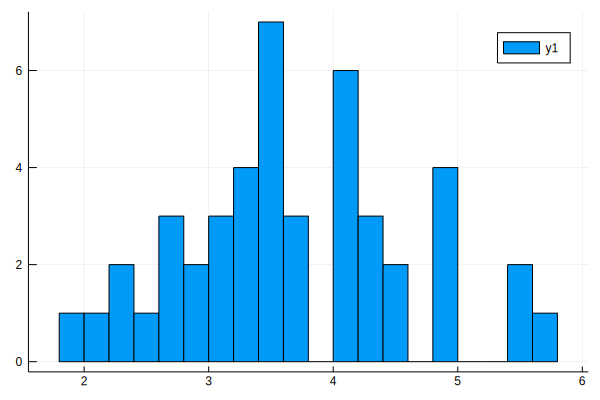

In [211]:
# We plot the predictions
histogram(pred_score_quad, nbins=20)

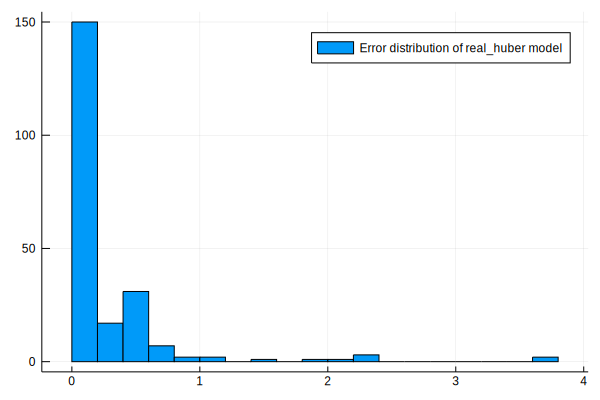

In [212]:
MAE_real_huber_error = abs.(vec((Rhat_real_huber - R_real)[Ω_real]))
MAE_real_huber_error = MAE_real_huber_error[MAE_real_huber_error.>0] #removing 0s as those are correct prediction. 
histogram(MAE_real_huber_error, nbins = 20, label = "Error distribution of real_huber model")

Now let's see how the L1 loss performs.

In [213]:
# form a low rank model by selecting appropriate losses, regularizer, and rank k
Random.seed!(1)
loss = L1Loss()    # BvSLoss with 5 levels
reg = QuadReg(.0001) # a tiny bit of quadratic regularization
k = 2                # we'll add the offset separately below 
glrm = GLRM(R_real, loss, reg, reg, k, obs=Ω_real)  # the GLRM object stores the model, data, and parameter estimate
add_offset!(glrm)    # adds an offset to the model

# fit low rank model
fit!(glrm)                            # alternating minimization
Rhat_real_l1 = impute(glrm)                   # imputed values 
MAE_real_l1 = sum(abs.(vec((Rhat_real_l1 - R_real)[Ω_real])))/(n_real*p_real)  # mean absolute error
@show MAE_real_l1;

Fitting GLRM
Iteration 10: objective value = 103.89874191562082
Iteration 20: objective value = 88.54689849967562
Iteration 30: objective value = 85.65494363671117
Iteration 40: objective value = 85.29484255219654
Iteration 50: objective value = 85.03920843393556
Iteration 60: objective value = 84.63516098916774
Iteration 70: objective value = 84.05759259439711
Iteration 80: objective value = 83.7425301824808
Iteration 90: objective value = 83.39892309481861
MAE_real_l1 = 0.016923025359258326


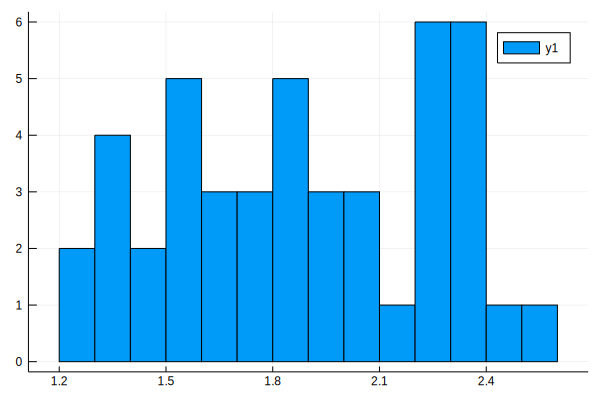

In [214]:
pred_score_l1 = mean(Rhat_real_l1, dims=2)
histogram(pred_score_l1, nbins=20)

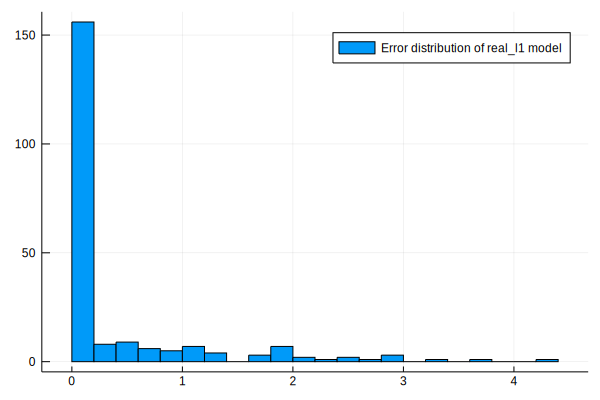

In [215]:
MAE_real_l1_error = abs.(vec((Rhat_real_l1 - R_real)[Ω_real]))
MAE_real_l1_error = MAE_real_l1_error[MAE_real_l1_error.>0] #removing 0s as those are correct prediction. 
histogram(MAE_real_l1_error, nbins = 20, label = "Error distribution of real_l1 model")

## Fit ratings with BvSLoss

For convenience in fitting the BvSLoss, we create a copy of the peer grades with missing entries imputed by 0. This won't affect the fit of the GLRM, since we restrict it to look only at the observed entries.

In [216]:
R_real_noNA = copy(R_real);
for row in 1:n_real
      for col in 1:p_real
        if  ismissing(R_real[row, col])
            R_real_noNA[row, col] = 0
        end
      end
end
R_real_noNA = Int.(R_real_noNA);

In [217]:
Random.seed!(1)
loss = BvSLoss(6, bin_loss=LogisticLoss())    # BvSLoss with 6 levels, using Logistic Loss as the underlying binary loss
# could also ask for nonnegative coefficients:
rx = lastentry1(QuadReg(.0001))
ry = OrdinalReg(QuadReg(.0001))

# rx = lastentry1(NonNegConstraint())
# ry = OrdinalReg(NonNegConstraint())
k = 2                # we'll add the offset separately below 
glrm = GLRM(R_real_noNA, loss, rx, ry, k, obs=Ω_real)  # the GLRM object stores the model, data, and parameter estimate

# initialize with random positive numbers
glrm.X = rand(size(glrm.X)...)
glrm.Y = rand(size(glrm.Y)...)

# fit low rank model 
fit!(glrm)                            # alternating minimization
Rhat_real_bvs = impute(glrm)                   # imputed values 
MAE_real_bvs = sum(abs.(vec((Rhat_real_bvs - R_real)[Ω_real])))/(n_real*p_real)  # mean absolute error
@show MAE_real_bvs;

Fitting GLRM
Iteration 10: objective value = 182.7461929038052
Iteration 20: objective value = 87.53711485533242
Iteration 30: objective value = 46.164561738856904
Iteration 40: objective value = 25.85514635194305
Iteration 50: objective value = 15.29525242206966
Iteration 60: objective value = 9.436042494866044
Iteration 70: objective value = 6.029275635266458
Iteration 80: objective value = 3.9678748078460377
Iteration 90: objective value = 2.69630620480035
Iteration 100: objective value = 1.9164084032347322
MAE_real_bvs = 0.0


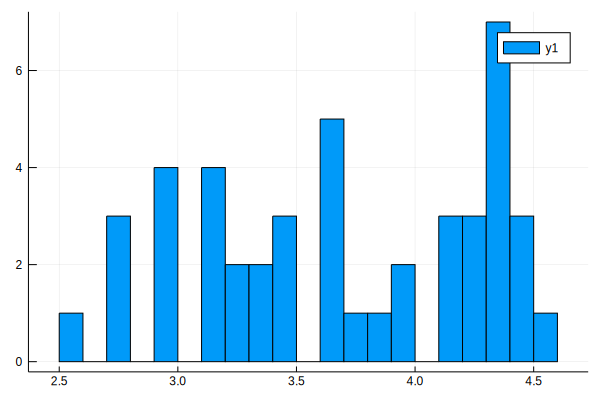

In [218]:
pred_score_bvs = mean(Rhat_real_bvs .- 0, dims=2);
histogram(pred_score_bvs, nbins = 20)

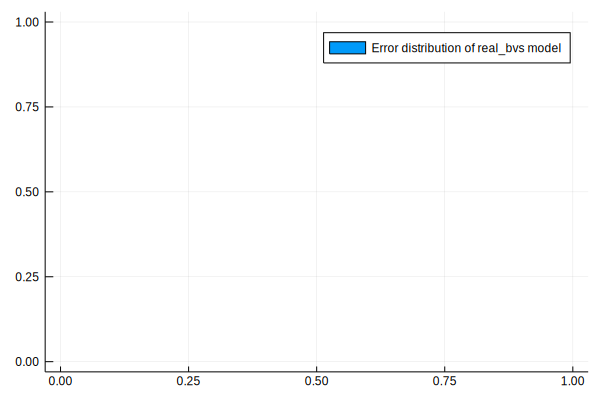

In [219]:
MAE_real_bvs_error = abs.(vec((Rhat_real_bvs - R_real)[Ω_real]))
MAE_real_bvs_error = MAE_real_bvs_error[MAE_real_bvs_error.>0] #removing 0s as those are correct prediction. 
histogram(MAE_real_bvs_error, nbins = 20, label = "Error distribution of real_bvs model")

**Question**: 

Fit at least one more model to this dataset. How did you choose which loss or regularizers to use? How does the error of your method compare to the error of the two models we fit above?

## My model 

In [220]:
# form a low rank model by selecting appropriate losses, regularizer, and rank k
loss = OvALoss(5, bin_loss=LogisticLoss())    # BvSLoss with 5 levels, using Logistic Loss as the underlying binary loss
# you could also ask for nonnegative coefficients:
reg = ZeroReg()
# rx = lastentry1(NonNegConstraint())
# ry = OrdinalReg(NonNegConstraint())
# rx = lastentry1(QuadReg(.0001))
# ry = OrdinalReg(QuadReg(.0001))
k = 2                # we'll add the offset separately below 
glrm = GLRM(R_real_noNA, loss, reg, reg, k, obs=Ω_real)  # the GLRM object stores the model, data, and parameter estimate


fit!(glrm)                            # alternating minimization
Rhat_new_model = impute(glrm)                   # imputed values 
MAE_new_model = sum(abs.(vec((Rhat_new_model - R_real)[Ω_real])))/(n_real*p_real)  # mean absolute error
print(MAE_new_model)

Fitting GLRM
Iteration 10: objective value = 73.70234584201386
Iteration 20: objective value = 3.9706884208952284
Iteration 30: objective value = 1.3208523078812924
Iteration 40: objective value = 0.5929807291114901
Iteration 50: objective value = 0.29876560018134296
Iteration 60: objective value = 0.1595264722565643
Iteration 70: objective value = 0.08803886383274138
Iteration 80: objective value = 0.04958037702073461
0.020591233435270133

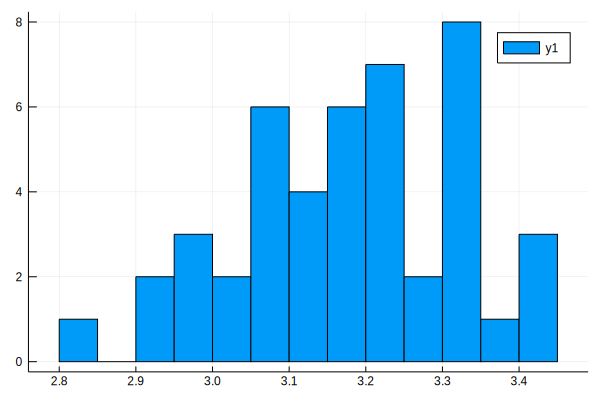

In [221]:
pred_score_new_model = mean(Rhat_new_model .- 0, dims=2);
histogram(pred_score_new_model, nbins = 20)

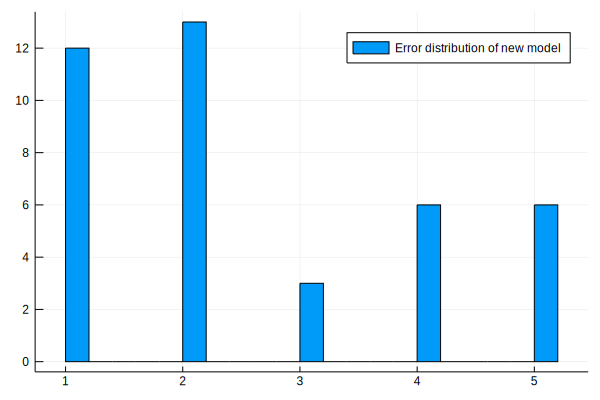

In [222]:
MAE_new_model_error = abs.(vec((Rhat_new_model - R_real)[Ω_real]))
MAE_new_model_error = MAE_new_model_error[MAE_new_model_error.>0] #removing 0s as those are correct prediction. 
histogram(MAE_new_model_error, nbins = 20, label = "Error distribution of new model")

**Question**: Comment on the performance of all of these models on real data. 
Your answer should discuss how the prediction errors are distributed.

## Answer

<br> <b> Answer </b>

Looking at the mean absolute errors (where we had an entry), <b> Bvs loss - looks to be doing a much better job than rest of the three models. </b>

<br> Huber loss: 0.0108
<br> L1 loss: 0.0169
<br> Bvs loss: 0.0
<br> one vs all loss (My model): 0.0212

<br> <b> Comment on prediction errors distributions </b> 

<br> Also as seen from the prediction error histograms above:
<br> 1. Huber and L1 have continuous error distribution. but majority of errors are confined within near class.
<br> 2. Bvs has zero loss. 
<br> 3. One vs all has categorical output and mistakes (erros) are fewer in number as compared to huber and L1, but distribution of errors is pretty wide. Which makes it a poor model. 

## (c) Summary

The ORIE 4741 must choose a method to grade your projects based on observable data. How would you like them to grade you?
1. average the observed scores 
2. average the scores imputed by matrix completion with quadratic loss
3. average the scores imputed by matrix completion with BvSLoss
4. average the scores imputed by matrix completion with my model

**Question**: Do you prefer simple grade averaging or matrix completion? If you prefer matrix completion, state what loss and regularizer you'd like the course staff to use (the polling result may affect your staff's choice!).

# Answer

<b> I would prefer matrix completion method with Big vs Small loss function with lastentry1(QuadReg) for X and OrdinalReg(QuadReg) regularizer for Y. </b>